# Ensembles

<h3> План семинара </h3>

* **Bagging** 
 - Bootstrap
 - Как построить доверительный интревал с помощью bootstrap
 - Описание композиции Bagging
 - Bagging в применении в DT

* **Bias-vairance trade-off**
  - Разложение ошибки на Bias и Variance
  - bias\variance для bagging и boosting
    
* **Random Forest** 
 - Алгоритм построения случайного леса
 - Применение RandomForest на реальной задаче (предсказание оттока клиентов)
 - Out-of-bag error
 
* **Основные выводы** 

In [1]:
from IPython.display import Image

import warnings
warnings.simplefilter("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
%matplotlib inline

from sklearn.datasets import load_digits, load_iris
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.ensemble import BaggingClassifier, BaggingRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score


### Bootstrap

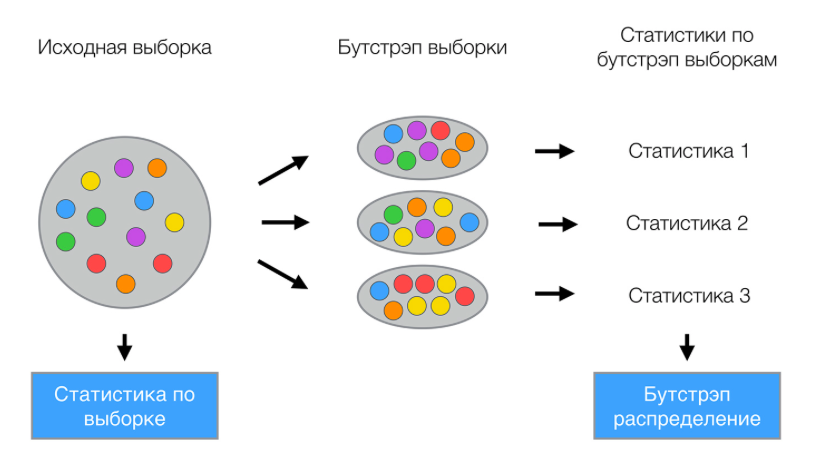
**Важно!**
    - Бутстрепная выборка имеет такой же размер, что и исходная
    - Генерация с повторениями

# Bagging
## $$a_{Bagging}(x) = \frac{1}{M}\sum_{i=1}^M a_i(x)$$

$a_i(x)$ - обучен на бутстреп-выборке $X^i$
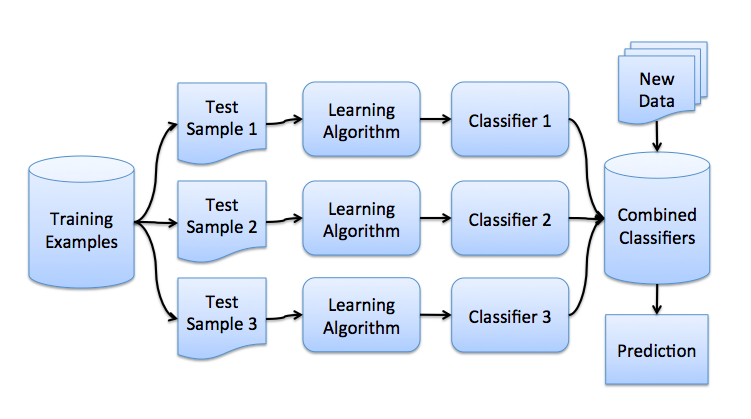

In [2]:
iris = load_iris()
X = iris.data
y = iris.target

f = X.shape[1] # Количество параметров

rnd_d3 = DecisionTreeClassifier(max_features=int(f**0.5)) #random splits
d3 = DecisionTreeClassifier()

In [3]:
print(f"Decision tree : {cross_val_score(d3, X, y).mean()}")
print(f"Bagging : {cross_val_score(BaggingClassifier(d3), X, y).mean()}")
print(f"Randomized Bagging : {cross_val_score(BaggingClassifier(rnd_d3), X, y).mean()}")

Decision tree : 0.9600000000000002
Bagging : 0.9533333333333334
Randomized Bagging : 0.9533333333333334


### Bias\variance для Bagging

Рассмотрим задачу регрессии с базовыми алгоритмами $b_1(x), .. ,b_n(x)$. Предположим, что существует истинная функция ответа для всех объектов $y(x)$, а также задано распределение на объектах $p(x)$. В этом случае мы можем записать ошибку каждой функции регрессии:

$$\varepsilon_i(x) = b_i(x) - y(x), i=1,..,n$$

Средняя ошибка построенных функций регрессии имеет вид:
    $$E_1 = \dfrac{1}{n} E_x \varepsilon_i^2(x)$$

Предположим, что ошибки несмещены и некоррелированы:
    $$E_x \varepsilon_i(x) = 0$$
    $$E_x \varepsilon_i(x) \varepsilon_j(x) = 0, i \neq j$$

Построим теперь новую функцию регрессии, которая будет усреднять ответы построенных нами функций:
    $$a(x) = \dfrac{1}{n} \sum_{i=1}^n b_i(x)$$

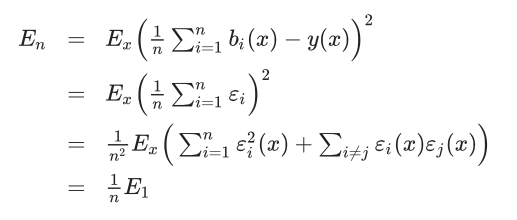

### Random Forest

##### Алгоритм построения случайного леса из $N$ деревьев

Для каждого $n = 1..N$:

Сгенерировать выборку $X_n$ с помощью бутстрэпа;
Построить решающее дерево $b_n$ по выборке $X_n$:
* по заданному критерию мы выбираем лучший признак, делаем разбиение в дереве по нему и так до исчерпания выборки
* дерево строится, пока в каждом листе не более $n_{min}$ объектов или пока не достигнем определенной высоты дерева
* при каждом разбиении сначала выбирается $m$ случайных признаков из $n$ исходных, и оптимальное разделение выборки ищется только среди них.  
Итоговый классификатор:
    $ a(x) = \frac{1}{N} \sum_{i=1}^{N}b_i(x) $  
    $m$ советуют выбирать равным:
- $\sqrt{n}$ для классификации
- $\dfrac{n}{3}$ для регрессии

## Random forest on real data

In [4]:
df = pd.read_csv('telecom_churn.csv')
numerical = []
for col in df.columns:
    if (df[col].dtype == 'int64') or (df[col].dtype == 'float64'):
        numerical.append(col)

X, y = df[numerical], df["Churn"]

shf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

rfc = RandomForestClassifier(random_state=42, n_jobs=-1, oob_score=True)

result = cross_val_score(rfc, X, y, cv=shf).mean()
result

0.9249965107536322

## Let's modify some base parameters

In [5]:
shuffle = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

train_acc = []
test_acc = []
trees_grid = [5, 10, 15, 20, 30, 50, 75, 100]
for max_trees in trees_grid:
    temp_train_acc = []
    temp_test_acc = []
    rfc = RandomForestClassifier(n_estimators=max_trees, random_state=42, n_jobs=-1, oob_score=True)
    for train_indx, test_indx in shuffle.split(X, y):
        X_train, X_test = X.iloc[train_indx], X.iloc[test_indx]
        y_train, y_test = y[train_indx], y[test_indx]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
    
train_acc = np.array(train_acc)
test_acc = np.array(test_acc)
print(f"The best test accuracy is {test_acc.max()} and its on classifier with \
      {trees_grid[np.argmax(test_acc.mean(axis=1))]} trees")

The best test accuracy is 0.9354354354354354 and its on classifier with       100 trees


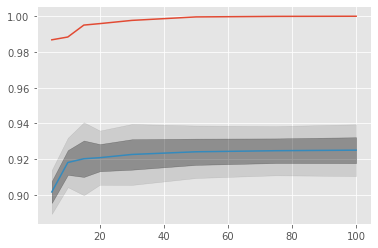

In [6]:
fig, ax = plt.subplots(1,1)

ax.plot(trees_grid, train_acc.mean(axis=1), label="train_acc")
ax.plot(trees_grid, test_acc.mean(axis=1), label="test_acc")
ax.fill_between(trees_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), 
                test_acc.mean(axis=1) + test_acc.std(axis=1), alpha=0.3, color='black')
ax.fill_between(trees_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), 
                test_acc.mean(axis=1) + 2*test_acc.std(axis=1), alpha=0.1, color='black')

In [7]:
shuffle = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

train_acc = []
test_acc = []
max_depth_grid = [3, 5, 7, 9, 11, 13, 15, 17, 20, 22, 24]
for max_depth in max_depth_grid:
    temp_train_acc = []
    temp_test_acc = []
    rfc = RandomForestClassifier(max_depth=max_depth, random_state=42, n_jobs=-1, oob_score=True)
    for train_indx, test_indx in shuffle.split(X, y):
        X_train, X_test = X.iloc[train_indx], X.iloc[test_indx]
        y_train, y_test = y[train_indx], y[test_indx]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
    
train_acc = np.array(train_acc)
test_acc = np.array(test_acc)
print(f"The best test accuracy is {test_acc.max()} and its on classifier with \
      {max_depth_grid[np.argmax(test_acc.mean(axis=1))]} depth")

The best test accuracy is 0.9354354354354354 and its on classifier with       24 depth


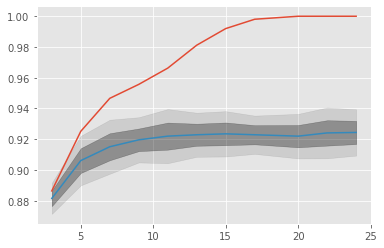

In [8]:
fig, ax = plt.subplots(1,1)

ax.plot(max_depth_grid, train_acc.mean(axis=1), label="train_acc")
ax.plot(max_depth_grid, test_acc.mean(axis=1), label="test_acc")
ax.fill_between(max_depth_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), 
                test_acc.mean(axis=1) + test_acc.std(axis=1), alpha=0.3, color='black')
ax.fill_between(max_depth_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), 
                test_acc.mean(axis=1) + 2*test_acc.std(axis=1), alpha=0.1, color='black')

In [9]:
shuffle = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

train_acc = []
test_acc = []
min_leaf_grid = [1, 3, 5, 7, 9, 11, 13, 15, 17, 20, 22, 24]
for min_leaf in min_leaf_grid:
    temp_train_acc = []
    temp_test_acc = []
    rfc = RandomForestClassifier(min_samples_leaf=min_leaf, random_state=42, n_jobs=-1, oob_score=True)
    for train_indx, test_indx in shuffle.split(X, y):
        X_train, X_test = X.iloc[train_indx], X.iloc[test_indx]
        y_train, y_test = y[train_indx], y[test_indx]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
    
train_acc = np.array(train_acc)
test_acc = np.array(test_acc)
print(f"The best test accuracy is {test_acc.max()} and its on classifier with \
      {min_leaf_grid[np.argmax(test_acc.mean(axis=1))]} leaf")

The best test accuracy is 0.9354354354354354 and its on classifier with       1 leaf


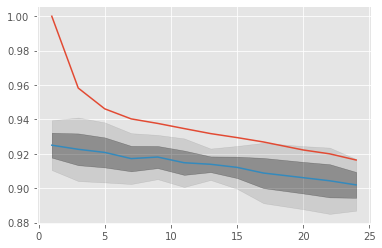

In [10]:
fig, ax = plt.subplots(1,1)

ax.plot(min_leaf_grid, train_acc.mean(axis=1), label="train_acc")
ax.plot(min_leaf_grid, test_acc.mean(axis=1), label="test_acc")
ax.fill_between(min_leaf_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), 
                test_acc.mean(axis=1) + test_acc.std(axis=1), alpha=0.3, color='black')
ax.fill_between(min_leaf_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), 
                test_acc.mean(axis=1) + 2*test_acc.std(axis=1), alpha=0.1, color='black')

Рассмотрим такой параметр как max_features. Для задач классификации по умолчанию используется $\sqrt{n}$, где $n$ — число признаков.

In [11]:
shuffle = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

train_acc = []
test_acc = []
max_features_grid = [2, 4, 6, 8, 10, 12, 14, 16]
for max_features in max_features_grid:
    temp_train_acc = []
    temp_test_acc = []
    rfc = RandomForestClassifier(max_features=max_features, random_state=42, n_jobs=-1, oob_score=True)
    for train_indx, test_indx in shuffle.split(X, y):
        X_train, X_test = X.iloc[train_indx], X.iloc[test_indx]
        y_train, y_test = y[train_indx], y[test_indx]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
    
train_acc = np.array(train_acc)
test_acc = np.array(test_acc)
print(f"The best test accuracy is {test_acc.max()} and its on classifier with \
      {max_features_grid[np.argmax(test_acc.mean(axis=1))]} leaf")

The best test accuracy is 0.9354354354354354 and its on classifier with       4 leaf


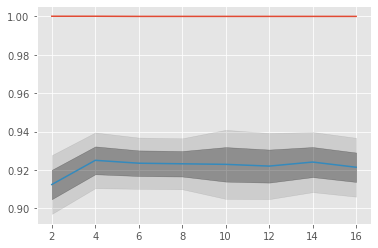

In [12]:
fig, ax = plt.subplots(1,1)

ax.plot(max_features_grid, train_acc.mean(axis=1), label="train_acc")
ax.plot(max_features_grid, test_acc.mean(axis=1), label="test_acc")
ax.fill_between(max_features_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), 
                test_acc.mean(axis=1) + test_acc.std(axis=1), alpha=0.3, color='black')
ax.fill_between(max_features_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), 
                test_acc.mean(axis=1) + 2*test_acc.std(axis=1), alpha=0.1, color='black')

In [13]:
#Now using GridSearchCV

grid = {'max_features': [4, 7, 10, 13], 'min_samples_leaf': [1, 3, 5, 7], 'max_depth': [5,10,15,20]}

rfc = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, oob_score=True)
shuffle = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

gcv = GridSearchCV(rfc, param_grid=grid, cv=shuffle, n_jobs=-1,verbose=1)
gcv.fit(X, y)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(n_jobs=-1, oob_score=True,
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [4, 7, 10, 13],
                         'min_samples_leaf': [1, 3, 5, 7]},
             verbose=1)

In [14]:
print(gcv.best_params_, gcv.best_score_)

{'max_depth': 20, 'max_features': 10, 'min_samples_leaf': 3} 0.925596661128895


## Overfitting in random forest

In [15]:
%%time

for n_estimators in [10, 40, 100, 200, 600, 1000]:
    clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=n_estimators, n_jobs=-1)
    clf.fit(X_train, y_train)
    train_acc, test_acc = accuracy_score(y_train, clf.predict(X_train)), accuracy_score(y_test, clf.predict(X_test))
    print(f"n_estimators = {n_estimators}, train_acc = {train_acc}, test_acc = {test_acc}")

n_estimators = 10, train_acc = 0.9902512185976753, test_acc = 0.918918918918919
n_estimators = 40, train_acc = 0.9985001874765654, test_acc = 0.9234234234234234
n_estimators = 100, train_acc = 1.0, test_acc = 0.9219219219219219
n_estimators = 200, train_acc = 1.0, test_acc = 0.9234234234234234
n_estimators = 600, train_acc = 1.0, test_acc = 0.9219219219219219
n_estimators = 1000, train_acc = 1.0, test_acc = 0.9234234234234234
Wall time: 20.6 s


In [16]:
%%time

for n_estimators in [10, 40, 100, 200, 600, 1000]:
    clf = BaggingClassifier(DecisionTreeClassifier(max_depth=7), n_estimators=n_estimators, n_jobs=-1)
    clf.fit(X_train, y_train)
    train_acc, test_acc = accuracy_score(y_train, clf.predict(X_train)), accuracy_score(y_test, clf.predict(X_test))
    print(f"n_estimators = {n_estimators}, train_acc = {train_acc}, test_acc = {test_acc}")

n_estimators = 10, train_acc = 0.9463817022872141, test_acc = 0.933933933933934
n_estimators = 40, train_acc = 0.9497562804649419, test_acc = 0.9264264264264265
n_estimators = 100, train_acc = 0.94750656167979, test_acc = 0.9234234234234234
n_estimators = 200, train_acc = 0.9493813273340832, test_acc = 0.9279279279279279
n_estimators = 600, train_acc = 0.948631421072366, test_acc = 0.924924924924925
n_estimators = 1000, train_acc = 0.9478815148106486, test_acc = 0.9264264264264265
Wall time: 12.9 s


In [17]:
%%time

for n_estimators in [10, 40, 100, 200, 600, 1000]:
    clf = BaggingClassifier(DecisionTreeClassifier(max_depth=14), n_estimators=n_estimators, n_jobs=-1)
    clf.fit(X_train, y_train)
    train_acc, test_acc = accuracy_score(y_train, clf.predict(X_train)), accuracy_score(y_test, clf.predict(X_test))
    print(f"n_estimators = {n_estimators}, train_acc = {train_acc}, test_acc = {test_acc}")

n_estimators = 10, train_acc = 0.9853768278965129, test_acc = 0.9234234234234234
n_estimators = 40, train_acc = 0.9876265466816648, test_acc = 0.9219219219219219
n_estimators = 100, train_acc = 0.990626171728534, test_acc = 0.9234234234234234
n_estimators = 200, train_acc = 0.989501312335958, test_acc = 0.9234234234234234
n_estimators = 600, train_acc = 0.989501312335958, test_acc = 0.9219219219219219
n_estimators = 1000, train_acc = 0.9902512185976753, test_acc = 0.9219219219219219
Wall time: 20 s


# OOBE
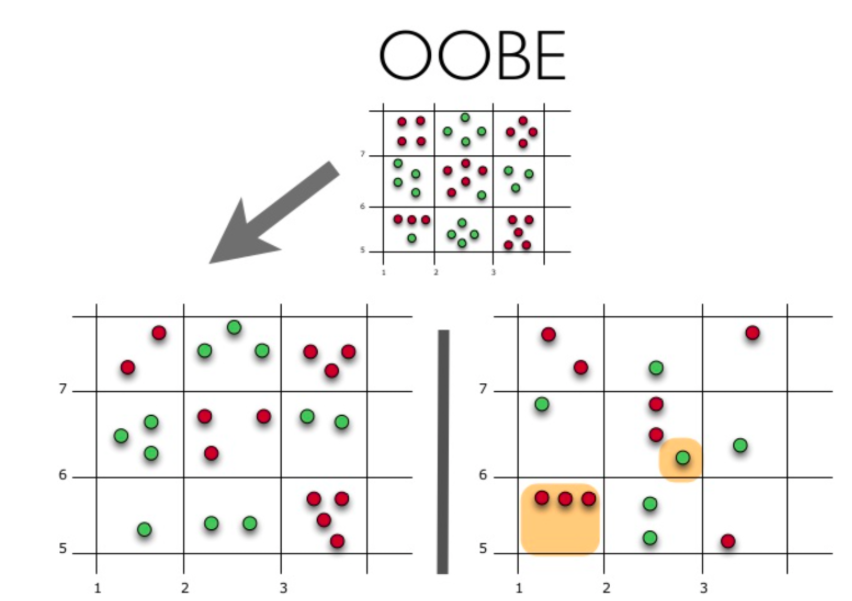

**Задача** Покажите, что примерно 37% примеров остаются вне выборки бутстрэпа и не используются при построении k-го дерева.  
**Решение** Пусть в выборке $l$ объектов. На каждом шаге все объекты попадают в подвыборку с возвращением равновероятно, т.е отдельный объект — с вероятностью $\dfrac{1}{l}$. Вероятность того, что объект НЕ попадет в подвыборку (т.е. его не взяли $l$ раз): $(1-\dfrac{1}{l})^l$


$$\lim_{l \rightarrow +\infty} (1-\dfrac{1}{l})^l = \dfrac{1}{e}$$

Тогда вероятность попадания конкретного объекта в подвыборку $1 - \dfrac{1}{e} \approx 63\%$.  
Out-of-Bag оценка — это усредненная оценка базовых алгоритмов на тех ~37% данных, на которых они не обучались.

# Feature Importance
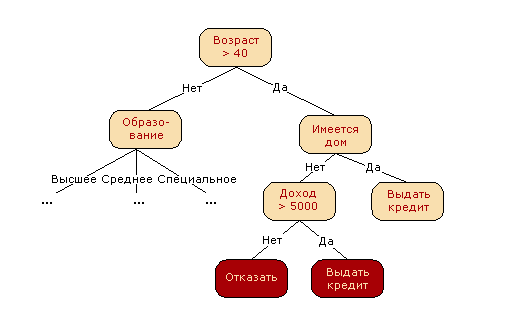

### Как вычисляется feature importance?

Каждый узел дерева использует конкретную фичу для максимизации критерия информативности. Для каждой фичи можно посчитать взвешенное (по размеру выборки) суммарное (по всем вершинам) изменение критерия информативности. 
И с помощью полученных результатов отсортировать фичи по важности.
Для леса, данные значения можно вначале усреднить по всем деревьям, а уже затем отсортировать.   
Также можно напрямую измерять влияние фичи на качество модели. Например случайно переставлять значения какой-то фичи в тестовой выборке и смотреть как сильно ухудшается качество.

In [19]:
hostel_data = pd.read_csv("hostel_factors.csv")
features = {"f1":u"Персонал",
"f2":u"Бронирование хостела ",
"f3":u"Заезд в хостел и выезд из хостела",
"f4":u"Состояние комнаты",
"f5":u"Состояние общей кухни",
"f6":u"Состояние общего пространства",
"f7":u"Дополнительные услуги",
"f8":u"Общие условия и удобства",
"f9":u"Цена/качество",
"f10":u"ССЦ"}
hostel_data

,hostel,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,rating
0,hostel1,0.675000,0.100000,0.300000,0.875000,0.250000,0.425000,0.350000,0.725000,0.400000,0.275000,9.0
1,hostel2,0.500000,0.000000,0.058824,0.573529,0.117647,0.382353,0.000000,0.161765,0.308824,0.000000,8.3
2,hostel3,0.520833,0.041667,0.020833,0.666667,0.229167,0.437500,0.270833,0.250000,0.395833,0.270833,8.6
3,hostel4,0.692308,0.038462,0.038462,0.346154,0.076923,0.307692,0.500000,0.115385,0.153846,0.269231,7.6
4,hostel5,0.620690,0.000000,0.000000,0.517241,0.172414,0.344828,0.172414,0.379310,0.103448,0.310345,8.7
5,hostel6,0.973684,0.052632,0.078947,0.552632,0.210526,0.473684,0.315789,0.684211,0.105263,0.263158,9.4
6,hostel7,0.643836,0.013699,0.013699,0.671233,0.178082,0.136986,0.191781,0.493151,0.191781,0.000000,8.4
7,hostel8,0.309091,0.163636,0.145455,0.545455,0.218182,0.345455,0.200000,0.454545,0.363636,0.254545,7.0
8,hostel9,0.666667,0.018519,0.037037,0.500000,0.185185,0.333333,0.259259,0.370370,0.000000,0.333333,8.9
9,hostel10,0.500000,0.000000,0.000000,0.616279,0.360465,0.337209,0.104651,0.255814,0.116279,0.023256,8.3


In [21]:
rfr = RandomForestRegressor(n_estimators=1000, max_features=10, random_state=0)
rfr.fit(hostel_data.drop(['hostel', 'rating'], axis=1), hostel_data['rating'])

RandomForestRegressor(max_features=10, n_estimators=1000, random_state=0)

Feature ranking:
1. Персонал 0.183150 
2. Цена/качество 0.147704 
3. Состояние общего пространства 0.128188 
4. Дополнительные услуги 0.116819 
5. ССЦ 0.105748 
6. Общие условия и удобства 0.088730 
7. Состояние общей кухни 0.074776 
8. Заезд в хостел и выезд из хостела 0.061881 
9. Бронирование хостела  0.053899 
10. Состояние комнаты 0.039105 


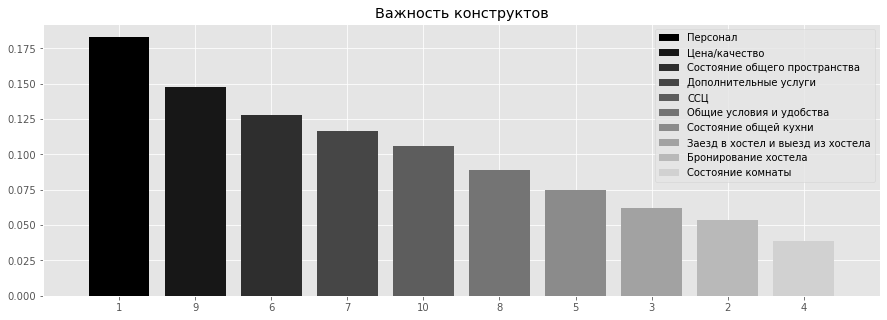

In [23]:
importances = rfr.feature_importances_
indices = np.argsort(importances)[::-1]
# Plot the feature importancies of the forest
num_to_plot = 10
feature_indices = [ind+1 for ind in indices[:num_to_plot]]

# Print the feature ranking
print("Feature ranking:")

for f in range(num_to_plot):
    print("%d. %s %f " % (f + 1, 
            features["f"+str(feature_indices[f])], 
            importances[indices[f]]))
plt.figure(figsize=(15,5))
plt.title(u"Важность конструктов")
bars = plt.bar(range(num_to_plot), 
               importances[indices[:num_to_plot]],
       color=([str(i/float(num_to_plot+1)) 
               for i in range(num_to_plot)]),
               align="center")
ticks = plt.xticks(range(num_to_plot), 
                   feature_indices)
plt.xlim([-1, num_to_plot])
plt.legend(bars, [u''.join(features["f"+str(i)]) 
                  for i in feature_indices])